In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from natsort import natsorted
import xarray as xr

import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
from codecarbon import track_emissions

In [24]:
data_path = "../../../all128.nc"
ds = xr.open_dataset(data_path)
print(f"{ds.channel=}")

selected_channel = ds['DN'].sel(channel='171A')
print(f"{selected_channel=}")

img = selected_channel.isel(time=0)
cmap = plt.get_cmap('sdoaia171')
img.plot(cmap=cmap)
plt.savefig("single.png")
plt.close()

keys = natsorted(ds['channel'].data)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for ax, key in zip(axes.ravel(), keys):
    data = ds['DN'].sel(channel=key).isel(time=0)
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    im = data.plot(cmap=cmap, ax=ax, add_colorbar=False)
    ax.set_title(key)
    ax.axis('off')

plt.savefig("multiple.png")
plt.close()

ds.channel=<xarray.DataArray 'channel' (channel: 9)> Size: 72B
array(['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A'],
      dtype=object)
Coordinates:
  * channel  (channel) object 72B '131A' '1600A' '1700A' ... '304A' '335A' '94A'
selected_channel=<xarray.DataArray 'DN' (time: 6130, x: 128, y: 128)> Size: 402MB
[100433920 values with dtype=float32]
Coordinates:
  * time     (time) int32 25kB 0 1 2 3 4 5 6 ... 6124 6125 6126 6127 6128 6129
  * x        (x) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
  * y        (y) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
    channel  <U4 16B '171A'


In [25]:
ds["DN"].sel(channel='171A').values.shape

(6130, 128, 128)

<Figure size 640x480 with 0 Axes>

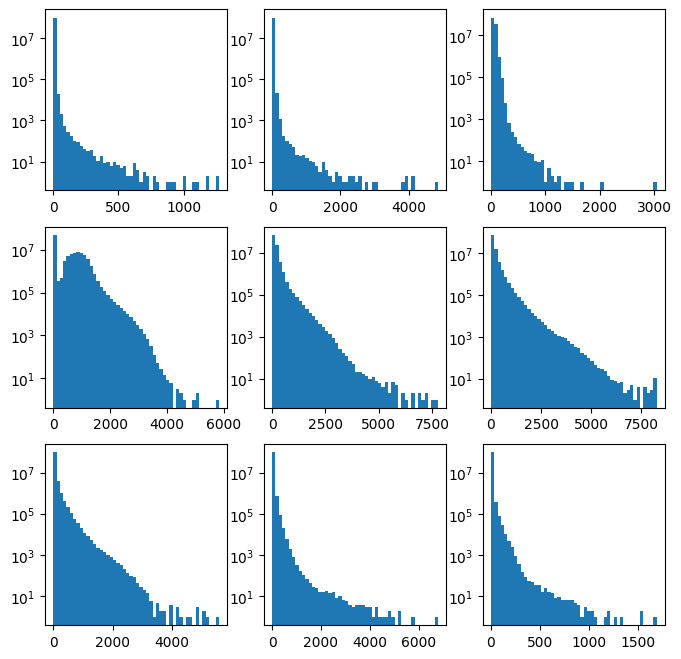

In [26]:
# plot distribution of pixel intensity for each channel
channels = ['94A', '131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A']

plt.clf()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.hist(ds["DN"].sel(channel=channels[i]).values.flatten(), bins=50)
    ax.set_yscale('log')
plt.show()

In [27]:
# NFs = [500, 1800, 1000, 5000, 6000, 7000, 3500, 4000, 1000] # eye balled these
# # for each channel normalize the pixels
# for NF, ch in zip(NFs, channels):
#     print(NF, ch)
#     ds["DN"].loc[dict(channel=ch)] = ds["DN"].sel(channel=ch)/NF

# plt.clf()
# fig, axes = plt.subplots(3, 3, figsize=(8, 8))
# for i, ax in enumerate(axes.ravel()):
#     ax.hist(ds["DN"].sel(channel=channels[i]).values.flatten(), bins=50)
#     ax.set_yscale('log')
# plt.show()

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import xarray as xr
import numpy as np

def stack_channels(ds):
    channels = ['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A']
    data_list = []
    for ch in channels:
        da = ds.sel(channel=ch)['DN']  # shape: (time, x, y)
        data_list.append(da.values)    # (time, x, y)
    data_array = np.stack(data_list, axis=1)  # shape: (time, channel, x, y)
    return data_array

full_data = stack_channels(ds)  # shape: (6130, 9, 128, 128)

# Input: Channel 94A (index 8)
# Output:  Channels (indices 0–7)
inputs_1 = full_data[:, 8, :64, :64]         # shape: (6130, 128, 128)
targets_1 = full_data[:, 0:8, :64, :64]      # shape: (6130, 8, 128, 128)
inputs_2 = np.rot90(full_data[:, 8, 64:, 64:], k=2, axes=(1, 2))         # shape: (6130, 128, 128)
targets_2 = np.rot90(full_data[:, 0:8, 64:, 64:], k=2, axes=(2, 3))      # shape: (6130, 8, 128, 128)
inputs_3 = np.rot90(full_data[:, 8, 64:, :64], k=3, axes=(1, 2))         # shape: (6130, 128, 128)
targets_3 = np.rot90(full_data[:, 0:8, 64:, :64], k=3, axes=(2, 3))      # shape: (6130, 8, 128, 128)
inputs_4 = np.rot90(full_data[:, 8, :64, 64:], k=1, axes=(1, 2))         # shape: (6130, 128, 128)
targets_4 = np.rot90(full_data[:, 0:8, :64, 64:], k=1, axes=(2, 3))      # shape: (6130, 8, 128, 128)

inputs = np.concatenate([inputs_1, inputs_2, inputs_3, inputs_4], axis=0)
targets = np.concatenate([targets_1, targets_2, targets_3, targets_4], axis=0)

# convert to torch
inputs_tensor = torch.from_numpy(inputs).float()
targets_tensor = torch.from_numpy(targets).float()

# Dataset-class
class ChannelPredictionDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs.unsqueeze(1)  # shape: (N, 1, 128, 128)
        self.targets = targets             # shape: (N, 8, 128, 128)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# create dataset
full_dataset = ChannelPredictionDataset(inputs_tensor, targets_tensor)

# Training/Test split (80% / 20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from codecarbon import track_emissions

class ChannelPredictorCNN(nn.Module):

    channels = ['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A']
    NFs = [500, 1800, 1000, 5000, 6000, 7000, 3500, 4000, 1000] # eye balled these
    def __init__(self):
        super(ChannelPredictorCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=3, padding=1)    # (B, 8, 128, 128)
        )

    def forward(self, x):
        # normalize the channels using the NFs
        x = x/self.NFs[-1]
        x = self.encoder(x)
        x = self.decoder(x)

        # loop through channels in x
        for i, channel in enumerate(self.channels[:-1]):
            x[:, i, :, :] *= self.NFs[i]
        return x


In [30]:
import torch
import torch.optim as optim

# Modell, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChannelPredictorCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

# Training
@track_emissions(project_name="sunny_days")
def train_model(model, train_loader, test_loader, epochs=10):
    channel_weights = [1, 5, 5, 1, 1, 1, 1, 1]
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_losses.append(train_loss/len(train_loader))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

        # Optional: Evaluate on test set
        val_losses.append(evaluate_model(model, test_loader))
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"  ➤ Test Loss: {total_loss/len(test_loader):.4f}")
    return total_loss/len(test_loader)


In [31]:
train_loss, val_loss = train_model(model, train_loader, test_loader, epochs=20)


[codecarbon WARNING @ 09:21:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:21:24] [setup] RAM Tracking...
[codecarbon INFO @ 09:21:25] [setup] CPU Tracking...
[codecarbon WARNING @ 09:21:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 09:21:26] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz
[codecarbon WARNING @ 09:21:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:21:26] [setup] GPU Tracking...
[codecarbon INFO @ 09:21:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:21:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 09:21:26] >>> Tracker's m

Epoch 1/20, Loss: 28312.4997
  ➤ Test Loss: 23697.0837


[codecarbon INFO @ 09:21:57] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:21:57] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:21:57] Energy consumed for All CPU : 0.001501 kWh
[codecarbon INFO @ 09:21:57] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 26.9895848624062 W
[codecarbon INFO @ 09:21:57] 0.001889 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:22:12] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:22:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:22:12] Energy consumed for All CPU : 0.002251 kWh
[codecarbon INFO @ 09:22:12] Energy consumed for all GPUs : 0.000335 kWh. Total GPU Power : 27.263432159531188 W
[codecarbon INFO @ 09:22:12] 0.002836 kWh of electricity used since the beginning.


Epoch 2/20, Loss: 14617.1048
  ➤ Test Loss: 10464.1828


[codecarbon INFO @ 09:22:27] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:22:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:22:27] Energy consumed for All CPU : 0.003001 kWh
[codecarbon INFO @ 09:22:27] Energy consumed for all GPUs : 0.000448 kWh. Total GPU Power : 27.275559255201212 W
[codecarbon INFO @ 09:22:27] 0.003783 kWh of electricity used since the beginning.


Epoch 3/20, Loss: 9859.8441


[codecarbon INFO @ 09:22:42] Energy consumed for RAM : 0.000417 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:22:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:22:42] Energy consumed for All CPU : 0.003751 kWh
[codecarbon INFO @ 09:22:42] Energy consumed for all GPUs : 0.000564 kWh. Total GPU Power : 27.703867019244782 W
[codecarbon INFO @ 09:22:42] 0.004731 kWh of electricity used since the beginning.


  ➤ Test Loss: 9159.4887


[codecarbon INFO @ 09:22:57] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:22:57] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:22:57] Energy consumed for All CPU : 0.004501 kWh
[codecarbon INFO @ 09:22:57] Energy consumed for all GPUs : 0.000678 kWh. Total GPU Power : 27.33950495040062 W
[codecarbon INFO @ 09:22:57] 0.005679 kWh of electricity used since the beginning.


Epoch 4/20, Loss: 8942.0903
  ➤ Test Loss: 8258.3135


[codecarbon INFO @ 09:23:12] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:23:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:23:12] Energy consumed for All CPU : 0.005252 kWh
[codecarbon INFO @ 09:23:12] Energy consumed for all GPUs : 0.000792 kWh. Total GPU Power : 27.37549490512367 W
[codecarbon INFO @ 09:23:12] 0.006627 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:23:27] Energy consumed for RAM : 0.000667 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:23:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:23:27] Energy consumed for All CPU : 0.006002 kWh
[codecarbon INFO @ 09:23:27] Energy consumed for all GPUs : 0.000907 kWh. Total GPU Power : 27.728541432352394 W
[codecarbon INFO @ 09:23:27] 0.007576 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:23:27] 0.024033 g.CO2eq/s mean an estimation of 757.89799

Epoch 5/20, Loss: 8334.5867
  ➤ Test Loss: 8921.2773


[codecarbon INFO @ 09:23:42] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:23:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:23:42] Energy consumed for All CPU : 0.006752 kWh
[codecarbon INFO @ 09:23:42] Energy consumed for all GPUs : 0.001022 kWh. Total GPU Power : 27.64804267546062 W
[codecarbon INFO @ 09:23:42] 0.008524 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:23:57] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:23:57] Delta energy consumed for CPU with constant : 0.000751 kWh, power : 180.0 W
[codecarbon INFO @ 09:23:57] Energy consumed for All CPU : 0.007502 kWh
[codecarbon INFO @ 09:23:57] Energy consumed for all GPUs : 0.001138 kWh. Total GPU Power : 27.712796520827627 W
[codecarbon INFO @ 09:23:57] 0.009473 kWh of electricity used since the beginning.


Epoch 6/20, Loss: 7882.7189
  ➤ Test Loss: 7603.1329


[codecarbon INFO @ 09:24:12] Energy consumed for RAM : 0.000917 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:24:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:24:12] Energy consumed for All CPU : 0.008252 kWh
[codecarbon INFO @ 09:24:12] Energy consumed for all GPUs : 0.001254 kWh. Total GPU Power : 27.728632652907045 W
[codecarbon INFO @ 09:24:12] 0.010422 kWh of electricity used since the beginning.


Epoch 7/20, Loss: 7581.1708
  ➤ Test Loss: 7125.0415


[codecarbon INFO @ 09:24:27] Energy consumed for RAM : 0.001000 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:24:27] Delta energy consumed for CPU with constant : 0.000751 kWh, power : 180.0 W
[codecarbon INFO @ 09:24:27] Energy consumed for All CPU : 0.009003 kWh
[codecarbon INFO @ 09:24:27] Energy consumed for all GPUs : 0.001370 kWh. Total GPU Power : 27.879997062199145 W
[codecarbon INFO @ 09:24:27] 0.011372 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:24:42] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:24:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:24:42] Energy consumed for All CPU : 0.009753 kWh
[codecarbon INFO @ 09:24:42] Energy consumed for all GPUs : 0.001486 kWh. Total GPU Power : 27.89046605782438 W
[codecarbon INFO @ 09:24:42] 0.012322 kWh of electricity used since the beginning.


Epoch 8/20, Loss: 7348.8250
  ➤ Test Loss: 7046.7110


[codecarbon INFO @ 09:24:57] Energy consumed for RAM : 0.001167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:24:57] Delta energy consumed for CPU with constant : 0.000751 kWh, power : 180.0 W
[codecarbon INFO @ 09:24:57] Energy consumed for All CPU : 0.010504 kWh
[codecarbon INFO @ 09:24:57] Energy consumed for all GPUs : 0.001601 kWh. Total GPU Power : 27.519059436977255 W
[codecarbon INFO @ 09:24:57] 0.013271 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:25:12] Energy consumed for RAM : 0.001250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:25:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:25:12] Energy consumed for All CPU : 0.011253 kWh
[codecarbon INFO @ 09:25:12] Energy consumed for all GPUs : 0.001717 kWh. Total GPU Power : 27.97585279455376 W
[codecarbon INFO @ 09:25:12] 0.014221 kWh of electricity used since the beginning.


Epoch 9/20, Loss: 7079.8010
  ➤ Test Loss: 7062.6668


[codecarbon INFO @ 09:25:27] Energy consumed for RAM : 0.001333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:25:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:25:27] Energy consumed for All CPU : 0.012004 kWh
[codecarbon INFO @ 09:25:27] Energy consumed for all GPUs : 0.001834 kWh. Total GPU Power : 27.845855392465396 W
[codecarbon INFO @ 09:25:27] 0.015170 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:25:27] 0.024094 g.CO2eq/s mean an estimation of 759.8188730121253 kg.CO2eq/year


Epoch 10/20, Loss: 6752.0328
  ➤ Test Loss: 6378.0357


[codecarbon INFO @ 09:25:42] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:25:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:25:42] Energy consumed for All CPU : 0.012753 kWh
[codecarbon INFO @ 09:25:42] Energy consumed for all GPUs : 0.001950 kWh. Total GPU Power : 27.911010143898263 W
[codecarbon INFO @ 09:25:42] 0.016120 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:25:57] Energy consumed for RAM : 0.001500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:25:57] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:25:57] Energy consumed for All CPU : 0.013504 kWh
[codecarbon INFO @ 09:25:57] Energy consumed for all GPUs : 0.002067 kWh. Total GPU Power : 28.07200566985733 W
[codecarbon INFO @ 09:25:57] 0.017070 kWh of electricity used since the beginning.


Epoch 11/20, Loss: 6533.2243
  ➤ Test Loss: 6480.8300


[codecarbon INFO @ 09:26:12] Energy consumed for RAM : 0.001583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:26:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:26:12] Energy consumed for All CPU : 0.014253 kWh
[codecarbon INFO @ 09:26:12] Energy consumed for all GPUs : 0.002181 kWh. Total GPU Power : 27.527593399337913 W
[codecarbon INFO @ 09:26:12] 0.018018 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:26:27] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:26:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:26:27] Energy consumed for All CPU : 0.015003 kWh
[codecarbon INFO @ 09:26:27] Energy consumed for all GPUs : 0.002299 kWh. Total GPU Power : 28.117164985864697 W
[codecarbon INFO @ 09:26:27] 0.018968 kWh of electricity used since the beginning.


Epoch 12/20, Loss: 6275.9703
  ➤ Test Loss: 6030.1191


[codecarbon INFO @ 09:26:42] Energy consumed for RAM : 0.001750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:26:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:26:42] Energy consumed for All CPU : 0.015753 kWh
[codecarbon INFO @ 09:26:42] Energy consumed for all GPUs : 0.002415 kWh. Total GPU Power : 27.903014004522312 W
[codecarbon INFO @ 09:26:42] 0.019918 kWh of electricity used since the beginning.


Epoch 13/20, Loss: 5969.1005


[codecarbon INFO @ 09:26:57] Energy consumed for RAM : 0.001833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:26:57] Delta energy consumed for CPU with constant : 0.000751 kWh, power : 180.0 W
[codecarbon INFO @ 09:26:57] Energy consumed for All CPU : 0.016504 kWh
[codecarbon INFO @ 09:26:57] Energy consumed for all GPUs : 0.002532 kWh. Total GPU Power : 27.980293171023465 W
[codecarbon INFO @ 09:26:57] 0.020868 kWh of electricity used since the beginning.


  ➤ Test Loss: 5906.8512


[codecarbon INFO @ 09:27:12] Energy consumed for RAM : 0.001916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:27:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:27:12] Energy consumed for All CPU : 0.017254 kWh
[codecarbon INFO @ 09:27:12] Energy consumed for all GPUs : 0.002649 kWh. Total GPU Power : 28.201153242253945 W
[codecarbon INFO @ 09:27:12] 0.021819 kWh of electricity used since the beginning.


Epoch 14/20, Loss: 5786.5138
  ➤ Test Loss: 5546.2454


[codecarbon INFO @ 09:27:27] Energy consumed for RAM : 0.002000 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:27:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:27:27] Energy consumed for All CPU : 0.018004 kWh
[codecarbon INFO @ 09:27:27] Energy consumed for all GPUs : 0.002765 kWh. Total GPU Power : 27.889011231052887 W
[codecarbon INFO @ 09:27:27] 0.022769 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:27:27] 0.024112 g.CO2eq/s mean an estimation of 760.4038322570191 kg.CO2eq/year
[codecarbon INFO @ 09:27:42] Energy consumed for RAM : 0.002083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:27:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:27:42] Energy consumed for All CPU : 0.018754 kWh
[codecarbon INFO @ 09:27:42] Energy consumed for all GPUs : 0.002883 kWh. Total GPU Power : 28.295530399961105 W
[codecarbon INFO @ 09:27:42] 0.023720 kWh of electricity us

Epoch 15/20, Loss: 5612.3014
  ➤ Test Loss: 5499.1619


[codecarbon INFO @ 09:27:57] Energy consumed for RAM : 0.002166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:27:57] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:27:57] Energy consumed for All CPU : 0.019504 kWh
[codecarbon INFO @ 09:27:57] Energy consumed for all GPUs : 0.003000 kWh. Total GPU Power : 27.955459983772425 W
[codecarbon INFO @ 09:27:57] 0.024670 kWh of electricity used since the beginning.


Epoch 16/20, Loss: 5492.0346


[codecarbon INFO @ 09:28:12] Energy consumed for RAM : 0.002249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:28:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:28:12] Energy consumed for All CPU : 0.020255 kWh
[codecarbon INFO @ 09:28:12] Energy consumed for all GPUs : 0.003117 kWh. Total GPU Power : 28.165779970876162 W
[codecarbon INFO @ 09:28:12] 0.025621 kWh of electricity used since the beginning.


  ➤ Test Loss: 5294.4532


[codecarbon INFO @ 09:28:27] Energy consumed for RAM : 0.002333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:28:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:28:27] Energy consumed for All CPU : 0.021005 kWh
[codecarbon INFO @ 09:28:27] Energy consumed for all GPUs : 0.003234 kWh. Total GPU Power : 27.930004281647708 W
[codecarbon INFO @ 09:28:27] 0.026571 kWh of electricity used since the beginning.


Epoch 17/20, Loss: 5329.4125
  ➤ Test Loss: 5215.8845


[codecarbon INFO @ 09:28:42] Energy consumed for RAM : 0.002416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:28:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:28:42] Energy consumed for All CPU : 0.021755 kWh
[codecarbon INFO @ 09:28:42] Energy consumed for all GPUs : 0.003351 kWh. Total GPU Power : 28.202046728685204 W
[codecarbon INFO @ 09:28:42] 0.027522 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:28:57] Energy consumed for RAM : 0.002499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:28:57] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:28:57] Energy consumed for All CPU : 0.022505 kWh
[codecarbon INFO @ 09:28:57] Energy consumed for all GPUs : 0.003469 kWh. Total GPU Power : 28.198739900670024 W
[codecarbon INFO @ 09:28:57] 0.028473 kWh of electricity used since the beginning.


Epoch 18/20, Loss: 5251.7774
  ➤ Test Loss: 5162.5546


[codecarbon INFO @ 09:29:12] Energy consumed for RAM : 0.002583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:29:12] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:29:12] Energy consumed for All CPU : 0.023255 kWh
[codecarbon INFO @ 09:29:12] Energy consumed for all GPUs : 0.003586 kWh. Total GPU Power : 28.063190749695288 W
[codecarbon INFO @ 09:29:12] 0.029424 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:29:27] Energy consumed for RAM : 0.002666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:29:27] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:29:27] Energy consumed for All CPU : 0.024005 kWh
[codecarbon INFO @ 09:29:27] Energy consumed for all GPUs : 0.003705 kWh. Total GPU Power : 28.56900680994106 W
[codecarbon INFO @ 09:29:27] 0.030376 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:29:27] 0.024137 g.CO2eq/s mean an estimation of 761.19171

Epoch 19/20, Loss: 5155.7251
  ➤ Test Loss: 4969.2104


[codecarbon INFO @ 09:29:42] Energy consumed for RAM : 0.002749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:29:42] Delta energy consumed for CPU with constant : 0.000750 kWh, power : 180.0 W
[codecarbon INFO @ 09:29:42] Energy consumed for All CPU : 0.024755 kWh
[codecarbon INFO @ 09:29:42] Energy consumed for all GPUs : 0.003822 kWh. Total GPU Power : 28.056888412068375 W
[codecarbon INFO @ 09:29:42] 0.031326 kWh of electricity used since the beginning.


Epoch 20/20, Loss: 5045.9589


[codecarbon INFO @ 09:29:54] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 09:29:54] Energy consumed for RAM : 0.002819 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:29:54] Delta energy consumed for CPU with constant : 0.000627 kWh, power : 180.0 W
[codecarbon INFO @ 09:29:54] Energy consumed for All CPU : 0.025382 kWh
[codecarbon INFO @ 09:29:54] Energy consumed for all GPUs : 0.003919 kWh. Total GPU Power : 27.992473033550617 W
[codecarbon INFO @ 09:29:54] 0.032120 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:29:55] Done!



  ➤ Test Loss: 4937.5914


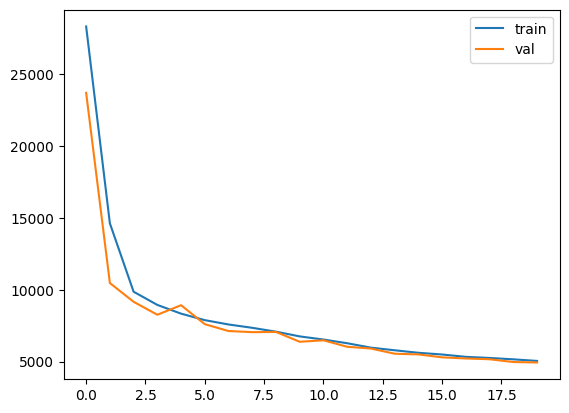

In [32]:
plt.clf()
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.show()

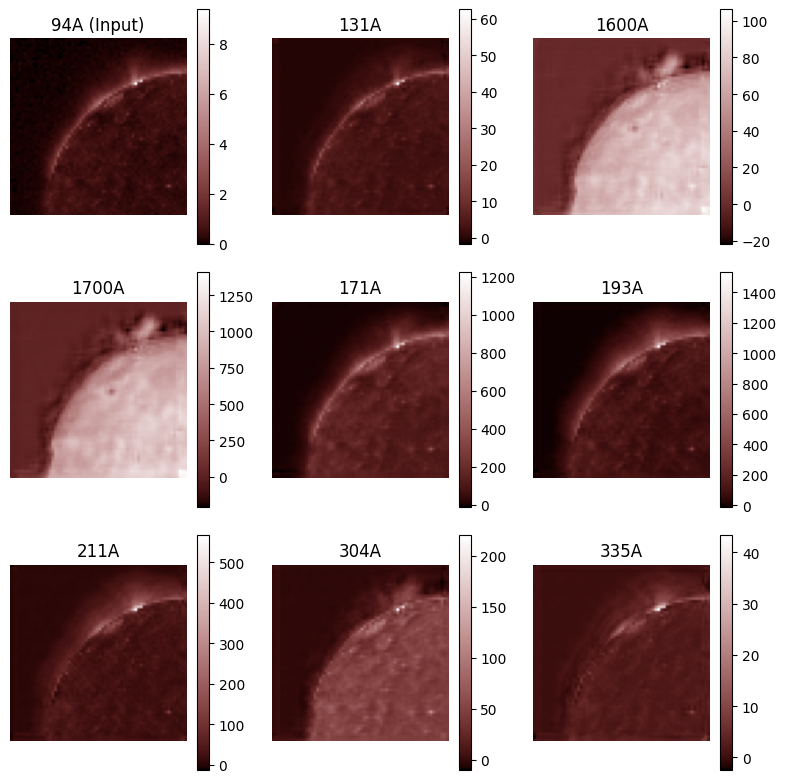

In [39]:
test_index = 71
import matplotlib.pyplot as plt
model.eval()

input_img, target_img = test_dataset[test_index]  # input: (1, 128, 128), target: (8, 128, 128)
input_img = input_img.unsqueeze(0).to(device)  # (1, 1, 128, 128)

with torch.no_grad():
    predicted = model(input_img).cpu().squeeze(0)  # (8, 128, 128)

input_np = input_img.cpu().squeeze(0).squeeze(0).numpy()  # (128, 128)
pred_np = predicted.numpy()  # (8, 128, 128)
target_np = target_img.numpy()

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
channels = ['94A (Input)', '131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A']

for i, (ax, ch) in enumerate(zip(axes.ravel(), channels)):
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    if ch == '94A (Input)':
        im = ax.imshow(input_np, cmap=cmap)
    else:
        im = ax.imshow(pred_np[i-1], cmap=cmap)
    
    ax.set_title(ch)
    ax.axis('off')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_3476\158985562.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 10 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_3476\158985562.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 11 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_3476\158985562.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 12 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_3476\158985562.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 13 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax)


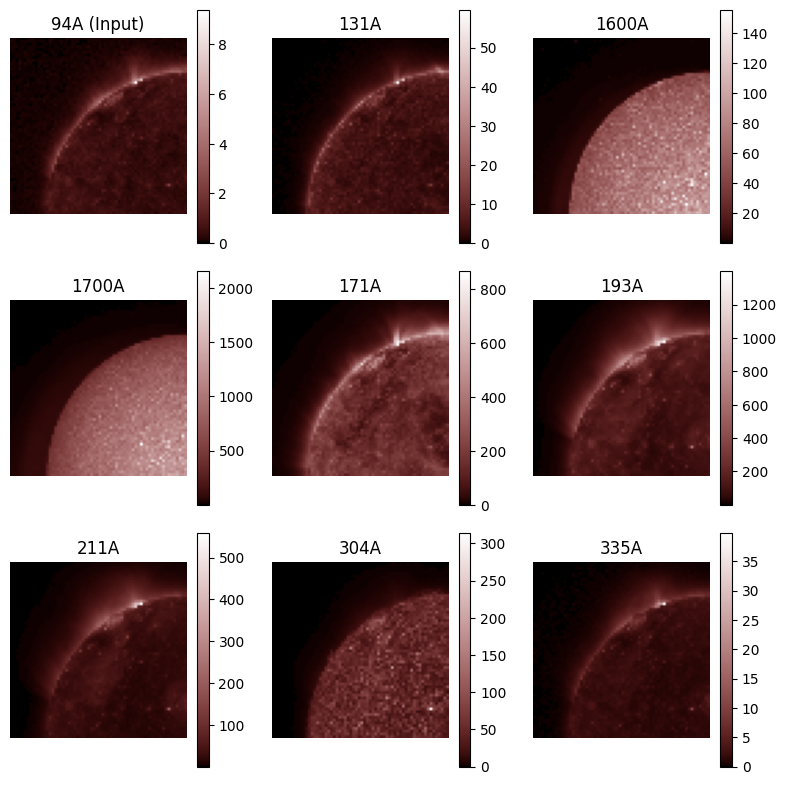

In [40]:
fig_2, axes_2 = plt.subplots(3, 3, figsize=(8, 8))
for i, (ax, ch) in enumerate(zip(axes_2.ravel(), channels)):
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    if ch == '94A (Input)':
        im = ax.imshow(input_np, cmap=cmap)
    else:
        im = ax.imshow(target_np[i-1], cmap=cmap)

    ax.set_title(ch)
    ax.axis('off')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()